# Introduction to Graph Theory

## Graph Modelling

### Learning Aims
* Modelling data in graph form to best solve a problem


### Learning Objectives
* Given a dataset that it not intrinsically modelled as a graph, remodel it such that it can be used to answer a specific question.

---

## Exploratory analysis of the US Airport Dataset

This dataset contains data for 25 years[1995-2015] of flights between various US airports and metadata about these routes. Taken from Bureau of Transportation Statistics, United States Department of Transportation.

Let's see what can we make out of this!

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
pass_air_data = pd.read_csv('data/passengers.csv')

In the `pass_air_data` dataframe we have the information of number of people that fly every year on a particular route on the list of airlines that fly that route.

In [4]:
pass_air_data.head()

,Unnamed: 0,YEAR,ORIGIN,DEST,UNIQUE_CARRIER_NAME,PASSENGERS
0,0,1990,ABE,ACY,{'US Airways Inc.'},73.0
1,1,1990,ABE,ATL,{'Eastern Air Lines Inc.'},73172.0
2,2,1990,ABE,AVL,{'Westair Airlines Inc.'},0.0
3,3,1990,ABE,AVP,"{'Westair Airlines Inc.', 'US Airways Inc.', '...",8397.0
4,4,1990,ABE,BHM,{'Eastern Air Lines Inc.'},59.0


In [5]:
import networkx as nx

passenger_graph = nx.from_pandas_edgelist(
    pass_air_data, source='ORIGIN', target='DEST', edge_attr=['YEAR', 'PASSENGERS', 'UNIQUE_CARRIER_NAME'], 
    create_using=nx.MultiDiGraph()
)

### Cleveland to Chicago, how many people fly this route?

In [7]:
record = passenger_graph['CLE']['ORD'][25]
record['PASSENGERS']

409943.0

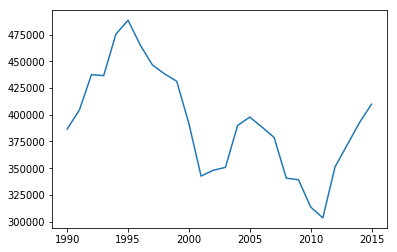

In [17]:
years = np.array([(r['YEAR'], r['PASSENGERS']) for r in passenger_graph['CLE']['ORD'].values()])

plt.plot(years[:, 0], years[:, 1]);

## Exercise

Find the busiest route in 1990 and in 2015 according to number of passengers, and plot the time series of number of passengers on these routes.

You can use the DataFrame instead of working with the network. It will be faster ;)
[5 mins]

In [18]:
temp = pass_air_data.groupby(['YEAR'])['PASSENGERS'].transform(max) == pass_air_data['PASSENGERS']

In [20]:
pass_air_data[temp][pass_air_data.YEAR.isin([1990, 2015])]

/Users/mjburgess/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Unnamed: 0,YEAR,ORIGIN,DEST,UNIQUE_CARRIER_NAME,PASSENGERS
3917,3917,1990,LAX,HNL,"{'Heavylift Cargo Airlines Lt', 'Hawaiian Airl...",1827164.0
445978,445978,2015,LAX,SFO,"{'Hawaiian Airlines Inc.', 'Delta Air Lines In...",1869066.0


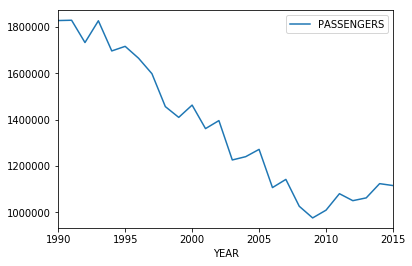

In [22]:
pass_air_data[(pass_air_data['ORIGIN'] == 'LAX') & (pass_air_data['DEST'] == 'HNL')].plot('YEAR', 'PASSENGERS');

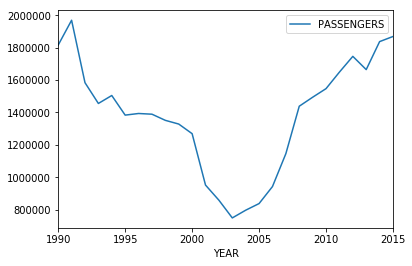

In [24]:
pass_air_data[(pass_air_data['ORIGIN'] == 'LAX') & (pass_air_data['DEST'] == 'SFO')].plot('YEAR', 'PASSENGERS');

So let's have a look at the important nodes in this network, i.e. important airports in this network. We'll use pagerank, betweenness centrality and degree centrality.

In [26]:
# nx.pagerank(passenger_graph)

In [27]:
def year_network(G, year):
    temp_g = nx.DiGraph()
    for i in G.edges(data=True):
        if i[2]['YEAR'] == year:
            temp_g.add_edge(i[0], i[1], weight=i[2]['PASSENGERS'])
    return temp_g

In [28]:
pass_2015 = year_network(passenger_graph, 2015)

In [29]:
len(pass_2015)

1258

In [30]:
len(pass_2015.edges())

25354

In [32]:
lat_long = pd.read_csv('data/GlobalAirportDatabase.txt', delimiter=':', header=None)

In [34]:
lat_long[lat_long[1].isin(list(pass_2015.nodes()))].sample(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
3383,KACT,ACT,WACO RGNL,WACO,USA,31,36,40,N,97,13,49,W,158,31.611,-97.23
3450,KCLE,CLE,CLEVELAND HOPKINS INTERNATIONAL,CLEVELAND,USA,41,24,42,N,81,50,59,W,242,41.412,-81.85


In [35]:
pos_dict = {}
for airport in lat_long[lat_long[1].isin(list(pass_2015.nodes()))].iterrows():
    pos_dict[airport[1][1]] = (airport[1][15], airport[1][14]) 

In [37]:
pos_dict['CLF']

(1.357, 52.755)

## Exercise

Using the position dictionary `pos_dict` create a plot of the airports, only the nodes not the edges.

- As we don't have coordinates for all the airports we have to create a subgraph first.
- Use `nx.subgraph(Graph, iterable of nodes)` to create the subgraph
- Use `nx.draw_networkx_nodes(G, pos)` to map the nodes. 

or 

- Just use a scatter plot :)

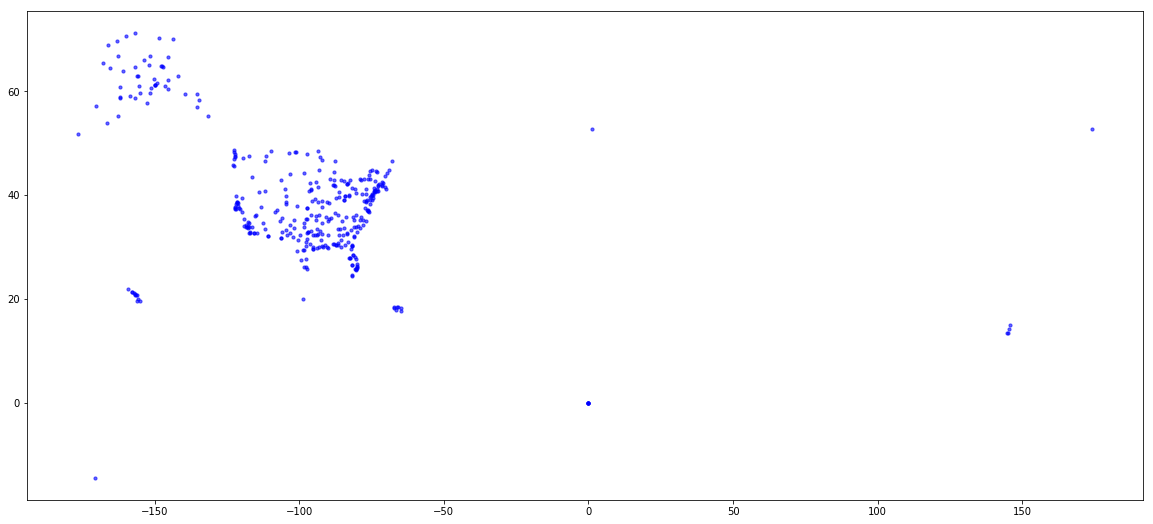

In [38]:
plt.figure(figsize=(20, 9))
G = nx.subgraph(pass_2015, pos_dict.keys())
nx.draw_networkx_nodes(G, pos=pos_dict, node_size=10, alpha=0.6, node_color='b')
# nx.draw_networkx_edges(G, pos=pos_dict, width=0.1, arrows=False)
plt.show()

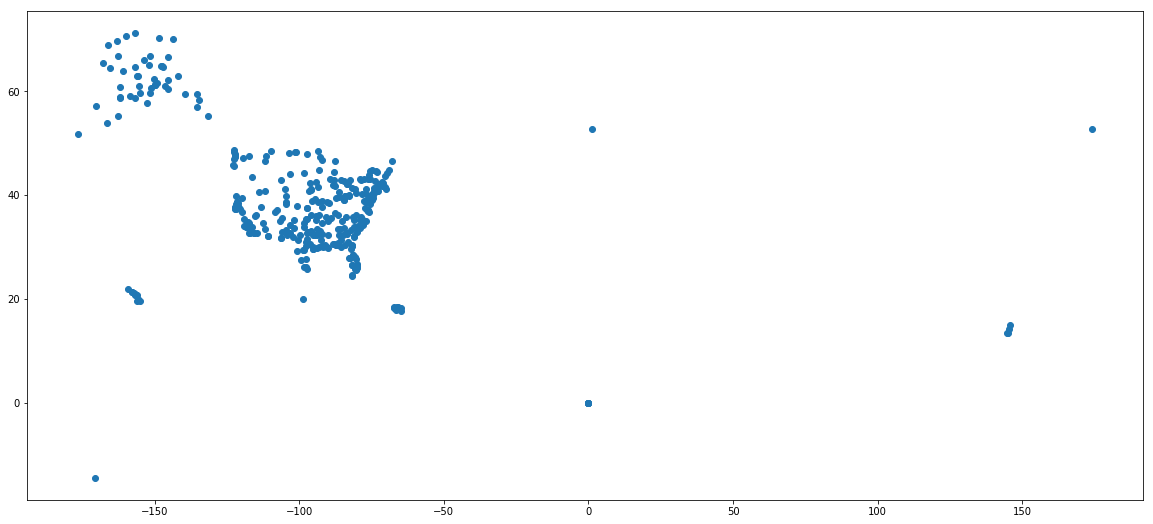

In [40]:
plt.figure(figsize=(20, 9))
x = [i[0] for i in pos_dict.values()]
y = [i[1] for i in pos_dict.values()]
plt.scatter(x, y);

### What about degree distribution of this network?

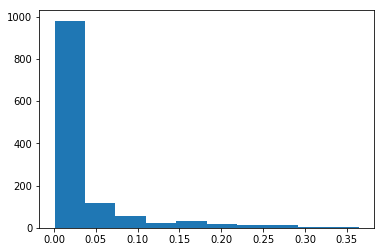

In [41]:
plt.hist(list(nx.degree_centrality(pass_2015).values()))
plt.show()

Let's plot a log log plot to get a better overview of this.

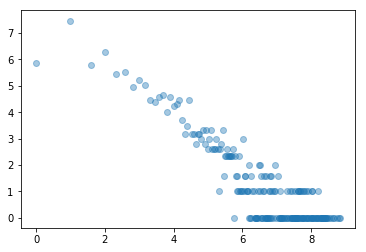

In [42]:
d = {}
for i, j in dict(nx.degree(pass_2015)).items():
    if j in d:
        d[j] += 1
    else:
        d[j] = 1
x = np.log2(list((d.keys())))
y = np.log2(list(d.values()))
plt.scatter(x, y, alpha=0.4)
plt.show()

### Directed Graphs

In [44]:
G = nx.DiGraph()

G.add_edge(1, 2, weight=1)

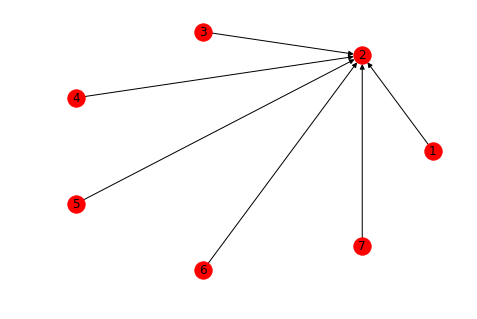

In [45]:
G.add_edges_from([(1, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2)])
nx.draw_circular(G, with_labels=True)

In [46]:
G.in_degree()

InDegreeView({1: 0, 2: 6, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0})

In [47]:
nx.pagerank(G)

{1: 0.0826448180198328,
 2: 0.5041310918810031,
 3: 0.0826448180198328,
 4: 0.0826448180198328,
 5: 0.0826448180198328,
 6: 0.0826448180198328,
 7: 0.0826448180198328}

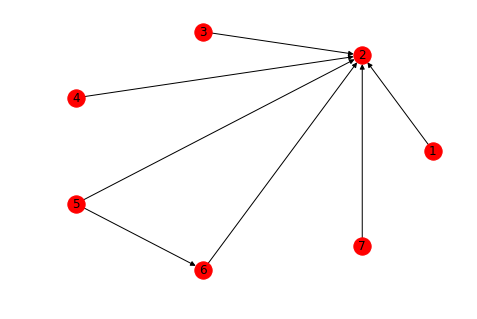

In [48]:
G.add_edge(5, 6)
nx.draw_circular(G, with_labels=True)

In [49]:
nx.pagerank(G)

{1: 0.08024854052495894,
 2: 0.4844028780560986,
 3: 0.08024854052495894,
 4: 0.08024854052495894,
 5: 0.08024854052495894,
 6: 0.11435441931910648,
 7: 0.08024854052495894}

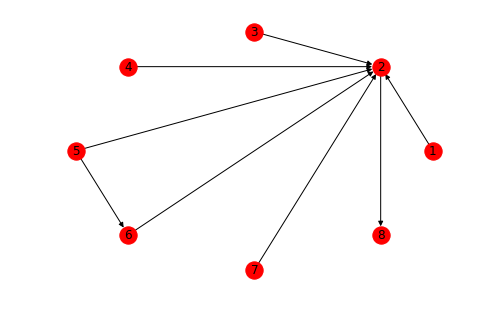

In [50]:
G.add_edge(2, 8)
nx.draw_circular(G, with_labels=True)

In [51]:
nx.pagerank(G)

{1: 0.05378612718073915,
 2: 0.3246687852772877,
 3: 0.05378612718073915,
 4: 0.05378612718073915,
 5: 0.05378612718073915,
 6: 0.0766454192258098,
 7: 0.05378612718073915,
 8: 0.3297551595932067}

### Moving back to Airports

In [52]:
sorted(nx.pagerank(pass_2015, weight=None).items(), key=lambda x:x[1], reverse=True)[:10]

[('ANC', 0.010425531156396332),
 ('HPN', 0.008715287139161587),
 ('FAI', 0.007865131822111036),
 ('DFW', 0.007168038232113773),
 ('DEN', 0.006557279519803018),
 ('ATL', 0.006367579588749718),
 ('ORD', 0.006178836107660135),
 ('YIP', 0.005821525504523931),
 ('ADQ', 0.005482597083474197),
 ('MSP', 0.005481962582230961)]

In [53]:
sorted(nx.betweenness_centrality(pass_2015).items(), key=lambda x:x[1], reverse=True)[0:10]

[('ANC', 0.28907458480586606),
 ('FAI', 0.08042857784594384),
 ('SEA', 0.06745549919241699),
 ('HPN', 0.06046810178534726),
 ('ORD', 0.045544143864829294),
 ('ADQ', 0.040170160000905696),
 ('DEN', 0.038543251364241436),
 ('BFI', 0.03811277548952854),
 ('MSP', 0.03774809342340624),
 ('TEB', 0.036229439542316354)]

In [54]:
sorted(nx.degree_centrality(pass_2015).items(), key=lambda x:x[1], reverse=True)[0:10]

[('ATL', 0.3643595863166269),
 ('ORD', 0.354813046937152),
 ('DFW', 0.3420843277645187),
 ('MSP', 0.3261734287987271),
 ('DEN', 0.31821797931583135),
 ('ANC', 0.3046937151949085),
 ('MEM', 0.29196499602227527),
 ('LAX', 0.2840095465393795),
 ('IAH', 0.28082736674622116),
 ('DTW', 0.27446300715990457)]

'ANC' is the airport code of Anchorage airport, a place in Alaska, and according to pagerank and betweenness centrality it is the most important airport in this network Isn't that weird? Thoughts?

related blog post: https://toreopsahl.com/2011/08/12/why-anchorage-is-not-that-important-binary-ties-and-sample-selection/

Let's look at weighted version, i.e taking into account the number of people flying to these places.

In [55]:
sorted(nx.betweenness_centrality(pass_2015, weight='weight').items(), key=lambda x:x[1], reverse=True)[0:10]

[('SEA', 2.2656145673621046e+50),
 ('ANC', 1.4996592705774285e+49),
 ('CDV', 1.1625885650735055e+49),
 ('ADQ', 8.328664868877188e+48),
 ('BFI', 6.99097447478957e+48),
 ('PHX', 3.84552515586718e+48),
 ('PDX', 3.120901981185909e+48),
 ('LRD', 4.583490839909188e+47),
 ('SIT', 1.7910862390475677e+46),
 ('FAI', 1.137539313512378e+46)]

In [56]:
sorted(nx.pagerank(pass_2015, weight='weight').items(), key=lambda x:x[1], reverse=True)[0:10]

[('ATL', 0.037535963029303135),
 ('ORD', 0.028329766122739346),
 ('SEA', 0.028274564067008245),
 ('ANC', 0.027127866647567035),
 ('DFW', 0.02570050418889442),
 ('DEN', 0.025260024346433315),
 ('LAX', 0.02394043498608451),
 ('PHX', 0.018373176636420224),
 ('CLT', 0.01780703930063076),
 ('LAS', 0.017649683141049966)]

## How reachable is this network?

We calculate the average shortest path length of this network, it gives us an idea about the number of jumps we need to make around the network to go from one airport to any other airport in this network.

In [58]:
nx.average_shortest_path_length(pass_2015)

NetworkXError: Graph is not weakly connected.

Wait, What??? This network is not connected. That seems like a really stupid thing to do.

In [68]:
list(list(nx.weakly_connected_components(pass_2015))[0])[:5]

['MTO', 'OWB', 'CIC', 'SEA', 'CDR']

### SPB, SSB, AIK anyone?

In [69]:
pass_air_data[(pass_air_data['YEAR'] == 2015) & (pass_air_data['ORIGIN'] == 'AIK')]

,Unnamed: 0,YEAR,ORIGIN,DEST,UNIQUE_CARRIER_NAME,PASSENGERS
433338,433338,2015,AIK,AIK,{'Wright Air Service'},0.0


In [70]:
pass_2015.remove_nodes_from(['SPB', 'SSB', 'AIK'])

In [71]:
nx.is_weakly_connected(pass_2015)

True

In [72]:
nx.is_strongly_connected(pass_2015)

False

### Strongly vs weakly connected graphs.

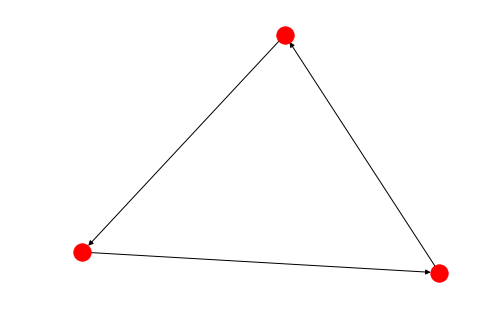

In [42]:
G = nx.DiGraph()
G.add_edge(1, 2)
G.add_edge(2, 3)
G.add_edge(3, 1)
nx.draw(G)

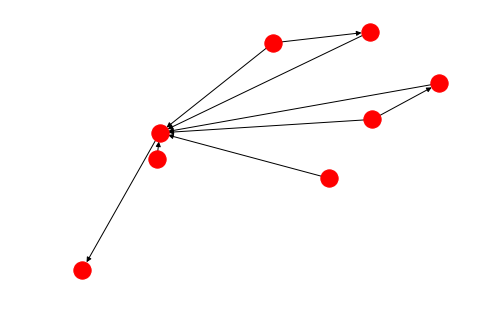

In [73]:
G.add_edge(3, 4)
nx.draw(G)

In [74]:
nx.is_strongly_connected(G)

False

In [76]:
list(nx.strongly_connected_components(pass_2015))[:5]

[{'BCE'}, {'WA3'}, {'WA9'}, {'TIW'}, {'RQV'}]

In [77]:
pass_air_data[(pass_air_data['YEAR'] == 2015) & (pass_air_data['DEST'] == 'TSP')]

,Unnamed: 0,YEAR,ORIGIN,DEST,UNIQUE_CARRIER_NAME,PASSENGERS
450245,450245,2015,ONT,TSP,{'Federal Express Corporation'},0.0


In [78]:
pass_2015_strong = max(nx.strongly_connected_component_subgraphs(pass_2015), key=len)

In [79]:
len(pass_2015_strong)

1190

In [80]:
nx.average_shortest_path_length(pass_2015_strong)

3.174661992635574

#### Exercise! (Actually this is a game :D)

How can we decrease the avg shortest path length of this network?

Think of an effective way to add new edges to decrease the avg shortest path length.
Let's see if we can come up with a nice way to do this, and the one who gets the highest decrease wins!!!

The rules are simple:
- You can't add more than 2% of the current edges( ~500 edges)

[10 mins]

In [81]:
sort_degree = sorted(nx.degree_centrality(pass_2015_strong).items(), key=lambda x:x[1], reverse=True)
top_count = 0
for n, v in sort_degree:
    count = 0
    for node, val in sort_degree:
        if node != n:
            if node not in pass_2015_strong.adj[n]:
                pass_2015_strong.add_edge(n, node)
                count += 1
                if count == 25:
                    break
    top_count += 1
    if top_count == 20:
        break

In [82]:
nx.average_shortest_path_length(pass_2015_strong)

3.0888508809747615

### What about airlines? Can we find airline specific reachability?

In [83]:
passenger_graph['JFK']['SFO'][25]

{'YEAR': 2015,
 'PASSENGERS': 1179941.0,
 'UNIQUE_CARRIER_NAME': "{'Delta Air Lines Inc.', 'Virgin America', 'American Airlines Inc.', 'Sun Country Airlines d/b/a MN Airlines', 'JetBlue Airways', 'Vision Airlines', 'United Air Lines Inc.'}"}

In [84]:
def str_to_list(a):
    return a[1:-1].split(', ')

In [85]:
for i in str_to_list(passenger_graph['JFK']['SFO'][25]['UNIQUE_CARRIER_NAME']):
    print(i)

'Delta Air Lines Inc.'
'Virgin America'
'American Airlines Inc.'
'Sun Country Airlines d/b/a MN Airlines'
'JetBlue Airways'
'Vision Airlines'
'United Air Lines Inc.'


In [86]:
%%time
for origin, dest in passenger_graph.edges():
    for key in passenger_graph[origin][dest]:
        passenger_graph[origin][dest][key]['airlines'] = str_to_list(passenger_graph[origin][dest][key]['UNIQUE_CARRIER_NAME'])

CPU times: user 20.6 s, sys: 121 ms, total: 20.8 s
Wall time: 21.2 s


### Exercise

Play around with United Airlines network.

- Extract a network for United Airlines flights from the metagraph `passenger_graph` for the year 2015
- Make sure it's a weighted network, where weight is the number of passengers.
- Find the number of airports and connections in this network
- Find the most important airport, according to PageRank and degree centrality.

In [87]:
united_network = nx.DiGraph()
for origin, dest in passenger_graph.edges():
    if 25 in passenger_graph[origin][dest]:
        if "'United Air Lines Inc.'" in passenger_graph[origin][dest][25]['airlines']:
            united_network.add_edge(origin, dest, weight=passenger_graph[origin][dest][25]['PASSENGERS'])

In [88]:
len(united_network.edges())

1097

In [89]:
sorted(nx.pagerank(united_network, weight='weight').items(), key=lambda x:x[1], reverse=True)[0:10]

[('ORD', 0.09229686412847604),
 ('DEN', 0.06951536832747153),
 ('LAX', 0.05547087049076451),
 ('SFO', 0.04520212084776551),
 ('IAH', 0.04398280474534501),
 ('EWR', 0.03754166218607773),
 ('ATL', 0.034778751100523315),
 ('DFW', 0.03419728511206331),
 ('PHX', 0.025365344038763896),
 ('MSP', 0.022269133819322266)]

In [90]:
sorted(nx.degree_centrality(united_network).items(), key=lambda x:x[1], reverse=True)[0:10]

[('ORD', 1.1729323308270676),
 ('DEN', 0.9172932330827067),
 ('IAH', 0.8195488721804511),
 ('EWR', 0.744360902255639),
 ('SFO', 0.5789473684210527),
 ('LAX', 0.5338345864661653),
 ('IAD', 0.5112781954887218),
 ('CLE', 0.39849624060150374),
 ('STL', 0.3609022556390977),
 ('PHL', 0.3308270676691729)]